In [10]:
# Cell 1: Imports and Load Data for Classification

import pandas as pd
import numpy as np
import os
from pathlib import Path
import datetime as dt
from datetime import timezone, timedelta
import logging
import json # For saving feature_columns_list
import joblib # For saving the model and scaler

from sklearn.model_selection import train_test_split # We'll do a chronological split manually
# RandomForest will be imported in Cell 3
from sklearn.preprocessing import StandardScaler # For feature scaling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix 

# --- Logging Setup ---
logger_name = f"model_training_classifier_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}" 
logger = logging.getLogger(logger_name)
if not logger.handlers: 
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s.%(funcName)s:%(lineno)d - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger.addHandler(ch)
else:
    logger.setLevel(logging.INFO)

# --- Configuration ---
current_notebook_dir = Path.cwd() # Assumes notebook is in notebooks/train/

# Correctly point to where feature_engineering.ipynb saved the CSV: project_root/notebooks/features/
# If train.ipynb is in project_root/notebooks/train/
# then current_notebook_dir.parent is project_root/notebooks/
FEATURES_DIR = current_notebook_dir.parent / "features" 

logger.info(f"Attempting to find feature files in: {FEATURES_DIR.resolve()}")

try:
    if not FEATURES_DIR.exists():
        # Fallback if FEATURES_DIR was not found as expected (e.g. if notebook structure changed)
        alt_features_dir = Path.cwd().parent.parent / "features" # Assuming project_root/features
        if alt_features_dir.exists():
            FEATURES_DIR = alt_features_dir
            logger.info(f"Primary FEATURES_DIR not found, using alternative: {FEATURES_DIR.resolve()}")
        else:
            # Last attempt, perhaps features are in the same dir as the 'train' notebook's parent ('notebooks/')
            # This would match if feature_engineering.ipynb was run from ./notebooks and saved there.
            # However, your log shows it saved to project_root/notebooks/features/
            # So the first FEATURES_DIR should be correct.
            # This is more of a safety net.
            # raise FileNotFoundError(f"The directory {FEATURES_DIR.resolve()} (and {alt_features_dir.resolve()}) does not exist. Please check the path.")
            # For your specific case, the path should be:
            # /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features/
            # If train.ipynb is at /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/train/
            # current_notebook_dir.parent = /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/
            # FEATURES_DIR = current_notebook_dir.parent / "features" is correct.
            pass # Let the error be caught by glob if FEATURES_DIR is truly wrong.


    # *** MODIFIED: Update glob pattern for v2_filtered_15m files ***
    # The filename includes the offset, e.g., "_15m_"
    # We can make the glob more general if the offset might change, or specific if we know it.
    # For now, let's be specific to ensure we pick up the 15m offset files.
    # If you use other offsets like 20m, 25m, you'll need to adjust this or use a broader pattern like "v2_filtered_*m_"
    feature_glob_pattern = "kalshi_btc_features_target_v2_filtered_15m_*.csv"
    feature_files = sorted(FEATURES_DIR.glob(feature_glob_pattern), key=os.path.getctime, reverse=True)
    
    if not feature_files:
        logger.warning(f"No '{feature_glob_pattern}' files found in {FEATURES_DIR.resolve()}. "
                       f"Falling back to 'kalshi_btc_features_target_v1_filtered_*.csv'...")
        feature_glob_pattern_v1_filt = "kalshi_btc_features_target_v1_filtered_*.csv"
        feature_files = sorted(FEATURES_DIR.glob(feature_glob_pattern_v1_filt), key=os.path.getctime, reverse=True)
        if not feature_files:
            raise FileNotFoundError(f"No feature CSV files found in {FEATURES_DIR.resolve()} matching EITHER "
                                    f"'{feature_glob_pattern}' OR '{feature_glob_pattern_v1_filt}'")
    
    FEATURES_CSV_PATH = feature_files[0]
    logger.info(f"Using features CSV: {FEATURES_CSV_PATH.resolve()}")

except FileNotFoundError as e:
    logger.critical(str(e))
    FEATURES_CSV_PATH = None
except Exception as e:
    logger.critical(f"Error finding features CSV: {e}", exc_info=True)
    FEATURES_CSV_PATH = None

# Output directory for trained classifier models
MODEL_OUTPUT_DIR = current_notebook_dir.parent / "trained_models/rf" 
MODEL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Trained classifier models will be saved in: {MODEL_OUTPUT_DIR.resolve()}")


# --- Load the Features DataFrame ---
df_model_data = pd.DataFrame()

if FEATURES_CSV_PATH and FEATURES_CSV_PATH.exists():
    try:
        df_model_data = pd.read_csv(FEATURES_CSV_PATH)
        logger.info(f"Successfully loaded features data from: {FEATURES_CSV_PATH.resolve()}")
        logger.info(f"Shape of loaded data: {df_model_data.shape}")
        
        print("--- Data Head (Raw from CSV) ---")
        with pd.option_context('display.max_columns', None): # Show all columns for head
            print(df_model_data.head())
        print("\n--- Data Info (Raw from CSV) ---")
        df_model_data.info(verbose=True, show_counts=True) # More detailed info
        # print("\n--- Data Description (Numerical, Raw from CSV) ---")
        # print(df_model_data.describe().to_string())
        
    except Exception as e:
        logger.critical(f"Error loading features CSV {FEATURES_CSV_PATH.resolve()}: {e}")
else:
    if FEATURES_CSV_PATH:
         logger.critical(f"Features CSV file not found at the specified path: {FEATURES_CSV_PATH.resolve()}")
    else:
         logger.critical("FEATURES_CSV_PATH was not set (likely due to an error finding the file). Cannot load data.")

if df_model_data.empty:
    logger.warning("DataFrame df_model_data is empty. Subsequent cells might fail.")

2025-05-21 16:56:30,603 - INFO - model_training_classifier_20250521_165630.<module>:38 - Attempting to find feature files in: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features
2025-05-21 16:56:30,605 - INFO - model_training_classifier_20250521_165630.<module>:80 - Using features CSV: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features/kalshi_btc_features_target_v2_filtered_15m_20250521_163917.csv
2025-05-21 16:56:30,606 - INFO - model_training_classifier_20250521_165630.<module>:92 - Trained classifier models will be saved in: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/rf
2025-05-21 16:56:34,004 - INFO - model_training_classifier_20250521_165630.<module>:101 - Successfully loaded features data from: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features/kalshi_btc_features_target_v2_filtered_15m_20250521_163917.csv
2025-05-21 16:56:34,005 - INFO - model_training_classifier_20250521_165630.<module>:102 - Shape of load

--- Data Head (Raw from CSV) ---
          kalshi_market_ticker  decision_point_ts_utc  kalshi_strike_price  \
0  KXBTCD-25MAY1522-T106249.99             1747357200            106249.99   
1  KXBTCD-25MAY1522-T106249.99             1747357260            106249.99   
2  KXBTCD-25MAY1522-T106249.99             1747357320            106249.99   
3  KXBTCD-25MAY1522-T106249.99             1747357380            106249.99   
4  KXBTCD-25MAY1522-T106249.99             1747357440            106249.99   

   btc_price_t_minus_1  btc_mom_5m  btc_mom_10m  btc_mom_15m  btc_mom_30m  \
0            103764.81       73.29       -69.79      -182.17        22.80   
1            103709.10       17.67      -111.60      -246.90       -68.90   
2            103785.66       83.21         7.89      -114.10      -109.26   
3            103691.25      -34.40         5.91      -227.89      -285.74   
4            103629.36     -110.19       -98.42      -303.61      -299.95   

   btc_mom_60m  btc_vol_15m  btc_sm

In [11]:
# Cell 2: Data Preprocessing, Target Transformation, Feature Selection, and Splitting

if df_model_data.empty:
    logger.error("df_model_data is empty. Cannot proceed with preprocessing and splitting. Please ensure Cell 1 ran correctly and loaded data.")
else:
    logger.info(f"Starting preprocessing for df_model_data with shape: {df_model_data.shape}")

    # --- 1. Ensure Chronological Order ---
    df_model_data.sort_values(by='decision_point_ts_utc', inplace=True)
    df_model_data.reset_index(drop=True, inplace=True)
    logger.info("Data sorted by 'decision_point_ts_utc'.")

    # --- 2. Define NEW Target Variable for Classification ---
    original_target_col = 'TARGET_btc_diff_from_strike'
    classification_target_col = 'TARGET_market_resolves_yes' 

    if original_target_col not in df_model_data.columns:
        logger.critical(f"Original target column '{original_target_col}' not found. Cannot create classification target.")
        raise ValueError(f"Missing required column: {original_target_col}")
    
    df_model_data[classification_target_col] = (df_model_data[original_target_col] > 0).astype(int)
    logger.info(f"Created binary classification target '{classification_target_col}'.")
    logger.info(f"Value counts for '{classification_target_col}':\n{df_model_data[classification_target_col].value_counts(normalize=True)}")


    # --- 3. Handle Missing Values (NaNs) in Features ---
    identifier_cols = ['kalshi_market_ticker', 'decision_point_ts_utc', 'kalshi_strike_price']
    # This feature_columns list will now contain all new and old features
    feature_columns = [
        col for col in df_model_data.columns 
        if col not in identifier_cols + [original_target_col, classification_target_col]
    ]
    logger.info(f"Full feature columns list ({len(feature_columns)}):")
    for i in range(0, len(feature_columns), 5): # Print in chunks for readability
        logger.info(f"  {feature_columns[i:i+5]}")


    nan_summary_before = df_model_data[feature_columns].isnull().sum()
    nan_summary_before = nan_summary_before[nan_summary_before > 0].sort_values(ascending=False)
    if not nan_summary_before.empty:
        logger.warning(f"NaN values found in feature columns BEFORE IMPUTATION:\n{nan_summary_before}")
    else:
        logger.info("No NaNs found in feature columns before imputation.")

    # --- Imputation Strategy (as implemented in your previous version) ---
    for col in feature_columns:
        if df_model_data[col].isnull().any(): 
            if 'btc_mom' in col or 'kalshi_mid_chg' in col: df_model_data[col].fillna(0, inplace=True)
            elif 'btc_vol' in col or 'kalshi_mid_vol' in col: df_model_data[col].fillna(df_model_data[col].median(), inplace=True)
            elif 'btc_sma' in col or 'btc_ema' in col: df_model_data[col].fillna(df_model_data[col].median(), inplace=True)
            elif 'btc_price_vs_sma' in col or 'btc_price_vs_ema' in col: df_model_data[col].fillna(1.0, inplace=True)
            elif 'btc_rsi' in col: df_model_data[col].fillna(50.0, inplace=True)
            elif 'btc_atr' in col: df_model_data[col].fillna(df_model_data[col].median(), inplace=True)
            elif col == 'distance_to_strike_norm_atr': df_model_data[col].fillna(0, inplace=True)
            elif col == 'kalshi_vs_btc_implied_spread': df_model_data[col].fillna(0, inplace=True)
            elif col == 'kalshi_yes_bid': df_model_data[col].fillna(0, inplace=True)
            elif col == 'kalshi_yes_ask': df_model_data[col].fillna(100, inplace=True)
            elif col == 'kalshi_spread': 
                df_model_data[col] = df_model_data['kalshi_yes_ask'].fillna(100) - df_model_data['kalshi_yes_bid'].fillna(0)
                df_model_data[col].fillna(100.0, inplace=True) 
            elif col == 'kalshi_mid_price': 
                df_model_data[col] = (df_model_data['kalshi_yes_bid'].fillna(0) + df_model_data['kalshi_yes_ask'].fillna(100)) / 2
                df_model_data[col].fillna(50.0, inplace=True)
            elif 'kalshi_volume_t_minus_1' in col or 'kalshi_open_interest_t_minus_1' in col: df_model_data[col].fillna(0, inplace=True)
            else: 
                if df_model_data[col].isnull().any(): 
                    logger.warning(f"Feature '{col}' has NaNs, using general fillna(0).")
                    df_model_data[col].fillna(0, inplace=True)

    if 'kalshi_yes_bid' in feature_columns and 'kalshi_yes_ask' in feature_columns:
        if 'kalshi_spread' in feature_columns:
            df_model_data['kalshi_spread'] = df_model_data['kalshi_yes_ask'] - df_model_data['kalshi_yes_bid']
        if 'kalshi_mid_price' in feature_columns:
            df_model_data['kalshi_mid_price'] = (df_model_data['kalshi_yes_bid'] + df_model_data['kalshi_yes_ask']) / 2
    
    nan_summary_after = df_model_data[feature_columns].isnull().sum()
    nan_summary_after = nan_summary_after[nan_summary_after > 0]
    if not nan_summary_after.empty:
        logger.error(f"STILL HAVE NaNs after targeted imputation! Columns:\n{nan_summary_after}")
        logger.info("Proceeding with dropna for remaining NaNs in features.")
        df_model_data.dropna(subset=feature_columns, inplace=True) # Drop rows if any NaNs persist
    else:
        logger.info("Successfully handled/imputed NaNs in feature columns.")
        
    original_row_count = len(df_model_data)
    df_model_data.dropna(subset=[classification_target_col], inplace=True)
    # Final check: ensure no NaNs in the feature columns that will be used for X
    df_model_data.dropna(subset=feature_columns, inplace=True)
    logger.info(f"Dropped {original_row_count - len(df_model_data)} rows due to any remaining NaNs in features or target.")
        
    if not df_model_data.empty:
        X = df_model_data[feature_columns].copy()
        y = df_model_data[classification_target_col].copy()
        logger.info(f"Defined X (features) with shape: {X.shape}") # This should now be (N, 40)
        logger.info(f"Defined y (binary target) with shape: {y.shape}")
        logger.info(f"Target y value counts:\n{y.value_counts(normalize=True)}")

        split_ratio = 0.8
        split_index = int(len(X) * split_ratio)
        X_train = X.iloc[:split_index]; y_train = y.iloc[:split_index] 
        X_test = X.iloc[split_index:]; y_test = y.iloc[split_index:]   

        logger.info(f"Data split chronologically:")
        logger.info(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        logger.info(f"  X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        
        if not X_train.empty and not X_test.empty :
            train_start_ts = df_model_data['decision_point_ts_utc'].iloc[X_train.index[0]]
            train_end_ts = df_model_data['decision_point_ts_utc'].iloc[X_train.index[-1]]
            test_start_ts = df_model_data['decision_point_ts_utc'].iloc[X_test.index[0]]
            test_end_ts = df_model_data['decision_point_ts_utc'].iloc[X_test.index[-1]]
            logger.info(f"  Training data from: {dt.datetime.fromtimestamp(train_start_ts, tz=timezone.utc).isoformat()} to {dt.datetime.fromtimestamp(train_end_ts, tz=timezone.utc).isoformat()}")
            logger.info(f"  Test data from:     {dt.datetime.fromtimestamp(test_start_ts, tz=timezone.utc).isoformat()} to {dt.datetime.fromtimestamp(test_end_ts, tz=timezone.utc).isoformat()}")
        else: logger.warning("Train or Test set is empty after split.")

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train) # Scaler is fit on the 40 features
        X_test_scaled = scaler.transform(X_test)

        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        logger.info("Features scaled using StandardScaler.")
        
        # *** MODIFIED: Save scaler and feature list with _v2 suffix ***
        scaler_path_v2 = MODEL_OUTPUT_DIR / "feature_scaler_classifier_v2.joblib"
        joblib.dump(scaler, scaler_path_v2)
        logger.info(f"Scaler for V2 features saved to: {scaler_path_v2}")
        
        feature_columns_list_path_v2 = MODEL_OUTPUT_DIR / "feature_columns_classifier_v2.json"
        with open(feature_columns_list_path_v2, 'w') as f:
            json.dump(feature_columns, f) # Save the full list of 40 feature names
        logger.info(f"List of V2 feature columns ({len(feature_columns)} features) saved to: {feature_columns_list_path_v2}")

    else:
        logger.error("df_model_data is empty after NaN handling. Cannot proceed.")
        X, y, X_train, y_train, X_test, y_test, X_train_scaled_df, X_test_scaled_df = [pd.DataFrame()]*8 
        scaler = None

2025-05-21 16:56:36,029 - INFO - model_training_classifier_20250521_165630.<module>:6 - Starting preprocessing for df_model_data with shape: (1157220, 44)
2025-05-21 16:56:36,142 - INFO - model_training_classifier_20250521_165630.<module>:11 - Data sorted by 'decision_point_ts_utc'.
2025-05-21 16:56:36,146 - INFO - model_training_classifier_20250521_165630.<module>:22 - Created binary classification target 'TARGET_market_resolves_yes'.
2025-05-21 16:56:36,148 - INFO - model_training_classifier_20250521_165630.<module>:23 - Value counts for 'TARGET_market_resolves_yes':
TARGET_market_resolves_yes
1    0.519676
0    0.480324
Name: proportion, dtype: float64
2025-05-21 16:56:36,149 - INFO - model_training_classifier_20250521_165630.<module>:33 - Full feature columns list (40):
2025-05-21 16:56:36,149 - INFO - model_training_classifier_20250521_165630.<module>:35 -   ['btc_price_t_minus_1', 'btc_mom_5m', 'btc_mom_10m', 'btc_mom_15m', 'btc_mom_30m']
2025-05-21 16:56:36,149 - INFO - model_tr

2025-05-21 16:56:42,426 - INFO - model_training_classifier_20250521_165630.<module>:9 - --- Starting Classification Model Training (Calibrated Random Forest) ---
2025-05-21 16:56:42,433 - INFO - model_training_classifier_20250521_165630.<module>:28 - Fitting base RandomForest model to check OOB score on 925776 samples...
2025-05-21 16:57:53,328 - INFO - model_training_classifier_20250521_165630.<module>:34 - Base RandomForest model training complete for OOB check.
2025-05-21 16:57:53,329 - INFO - model_training_classifier_20250521_165630.<module>:36 -   Base Model Out-of-Bag (OOB) Score: 0.9567
2025-05-21 16:57:53,329 - INFO - model_training_classifier_20250521_165630.<module>:45 - Training CalibratedRandomForest_classifier_v2 (Calibrated RF with sigmoid) on 925776 samples...
2025-05-21 16:57:53,347 - INFO - model_training_classifier_20250521_165630.<module>:60 - Model parameters for CalibratedClassifierCV: {'cv': 3, 'ensemble': 'auto', 'estimator__bootstrap': True, 'estimator__ccp_alp

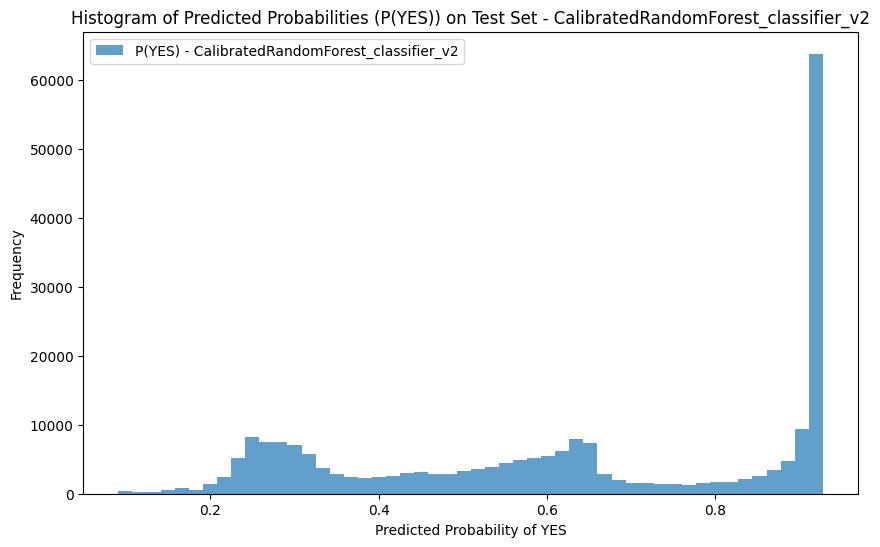

2025-05-21 16:59:52,841 - INFO - model_training_classifier_20250521_165630.<module>:105 - Description of P(YES) for CalibratedRandomForest_classifier_v2 on test set:
count    231444.000000
mean          0.630462
std           0.257416
min           0.090574
25%           0.382442
50%           0.631805
75%           0.915503
max           0.927912
2025-05-21 16:59:52,842 - INFO - model_training_classifier_20250521_165630.<module>:108 - 
--- Confusion Matrix (Test Set) - CalibratedRandomForest_classifier_v2 ---
2025-05-21 16:59:52,844 - INFO - model_training_classifier_20250521_165630.<module>:110 - 
[[ 73615  38715]
 [  3963 115151]]
2025-05-21 16:59:52,845 - INFO - model_training_classifier_20250521_165630.<module>:113 -   True Negatives (TN):  73615
2025-05-21 16:59:52,845 - INFO - model_training_classifier_20250521_165630.<module>:114 -   False Positives (FP): 38715 (Type I Error)
2025-05-21 16:59:52,845 - INFO - model_training_classifier_20250521_165630.<module>:115 -   False Negat


--- Sample of Test Set Predictions vs Actuals (CalibratedRandomForest_classifier_v2) ---
        actual_target_resolves_yes  predicted_class_resolves_yes  predicted_proba_resolves_yes  original_target_diff         kalshi_market_ticker  decision_point_ts_utc
925776                           0                             0                      0.181668              -1303.46  KXBTCD-25MAY0917-T104499.99             1746692640
925777                           1                             1                      0.507396                529.52  KXBTCD-25MAY0817-T101999.99             1746692640
925778                           1                             1                      0.542735                696.54  KXBTCD-25MAY0917-T102499.99             1746692640
925779                           1                             1                      0.768921               2196.54  KXBTCD-25MAY0917-T100999.99             1746692640
925780                           1                             1 

2025-05-21 16:59:53,118 - INFO - model_training_classifier_20250521_165630.<module>:176 - Trained CalibratedRandomForest_classifier_v2 model saved to: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/rf/CalibratedRandomForest_classifier_v2.joblib
2025-05-21 16:59:53,119 - INFO - model_training_classifier_20250521_165630.<module>:190 - CalibratedRandomForest_classifier_v2 hyperparameters saved to: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/rf/CalibratedRandomForest_classifier_v2_hyperparams.json


In [12]:
# Cell 3: Classification Model Training and Evaluation

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV # For probability calibration

if 'X_train_scaled_df' not in globals() or X_train_scaled_df.empty:
    logger.error("Scaled training data (X_train_scaled_df) not found or is empty. Please ensure Cell 2 ran successfully.")
else:
    logger.info("--- Starting Classification Model Training (Calibrated Random Forest) ---")

    # --- 1. Initialize Base RandomForestClassifier Model ---
    # Consider adjusting max_depth or min_samples_leaf/split if AUC was still too high
    # on the 15m filtered data, to make the base model slightly less complex.
    base_rf_model = RandomForestClassifier(
        n_estimators=200,        
        max_depth=12,             # Example: Reduced max_depth slightly
        min_samples_split=20,     # Example: Increased min_samples_split
        min_samples_leaf=10,      # Example: Increased min_samples_leaf
        class_weight='balanced_subsample', 
        random_state=42,
        n_jobs=-1,                
        oob_score=True            # OOB score for the base model
    )
    
    model_name = "CalibratedRandomForest_classifier_v2" # Updated model name for artifacts
    
    # Optionally, fit the base model to check its OOB score before calibration
    logger.info(f"Fitting base RandomForest model to check OOB score on {X_train_scaled_df.shape[0]} samples...")
    if 'y_train' not in globals() or y_train.empty:
        logger.error("y_train (binary target) is not available. Cannot train base model.")
    else:
        try:
            base_rf_model.fit(X_train_scaled_df, y_train) # Fit on scaled data
            logger.info(f"Base RandomForest model training complete for OOB check.")
            if hasattr(base_rf_model, 'oob_score_') and base_rf_model.oob_score_: # Check if oob_score was calculated
                 logger.info(f"  Base Model Out-of-Bag (OOB) Score: {base_rf_model.oob_score_:.4f}")
            else:
                logger.warning("  Base Model OOB Score not available (oob_score=True might not have run or failed).")
        except Exception as e:
            logger.error(f"Error fitting base RF model for OOB check: {e}", exc_info=True)
    
    # --- 2. Initialize and Train CalibratedClassifierCV ---
    # 'sigmoid' is generally more robust than 'isotonic', especially if the probability curve isn't strictly monotonic.
    # cv=3 or cv=5 is common.
    logger.info(f"Training {model_name} (Calibrated RF with sigmoid) on {X_train_scaled_df.shape[0]} samples...")
    # The CalibratedClassifierCV will re-fit the base_rf_model internally during its cross-validation.
    # So, the base_rf_model instance above is primarily for checking OOB if desired.
    # For the final calibrated model, a new base estimator is effectively used by CalibratedClassifierCV.
    # To pass the same params, we can re-instantiate or pass the fitted one (it gets cloned).
    # It's often cleaner to pass an unfitted estimator to CalibratedClassifierCV.
    calibrated_classifier_model = CalibratedClassifierCV(
        RandomForestClassifier( # Pass a new instance with the same params
            n_estimators=200, max_depth=12, min_samples_split=20, min_samples_leaf=10,
            class_weight='balanced_subsample', random_state=42, n_jobs=-1, oob_score=False # OOB not used by CalibratedCV directly
        ),
        method='sigmoid', 
        cv=3 # Number of folds for calibration
    )
    
    logger.info(f"Model parameters for CalibratedClassifierCV: {calibrated_classifier_model.get_params()}")
    
    if 'y_train' not in globals() or y_train.empty:
        logger.error("y_train (binary target) is not available. Cannot train calibrated model.")
    else:
        try:
            calibrated_classifier_model.fit(X_train_scaled_df, y_train) # Fit on scaled data
            logger.info(f"{model_name} model training complete.")
            # CalibratedClassifierCV itself does not have an oob_score_ attribute.

            # --- 3. Make Predictions on the Test Set ---
            logger.info(f"Making predictions with {model_name} on the test set ({X_test_scaled_df.shape[0]} samples)...")
            y_pred_test_class = calibrated_classifier_model.predict(X_test_scaled_df)
            y_pred_test_proba = calibrated_classifier_model.predict_proba(X_test_scaled_df)[:, 1]

            # --- 4. Evaluate Model Performance (Classification Metrics) ---
            # (This section remains largely the same, just uses calibrated_classifier_model and model_name)
            if 'y_test' not in globals() or y_test.empty:
                logger.error("y_test (binary target) is not available. Cannot evaluate model.")
            else:
                accuracy = accuracy_score(y_test, y_pred_test_class)
                precision = precision_score(y_test, y_pred_test_class, zero_division=0)
                recall = recall_score(y_test, y_pred_test_class, zero_division=0)
                f1 = f1_score(y_test, y_pred_test_class, zero_division=0)
                try: roc_auc = roc_auc_score(y_test, y_pred_test_proba)
                except ValueError as e: logger.warning(f"Could not calculate ROC AUC: {e}"); roc_auc = np.nan
                logloss = log_loss(y_test, y_pred_test_proba)

                logger.info(f"\n--- {model_name} Evaluation Metrics (Test Set) ---")
                logger.info(f"  Accuracy:          {accuracy:.4f}")
                logger.info(f"  Precision:         {precision:.4f}")
                logger.info(f"  Recall (TPR):      {recall:.4f}")
                logger.info(f"  F1-Score:          {f1:.4f}")
                logger.info(f"  ROC AUC:           {roc_auc:.4f}")
                logger.info(f"  Log Loss:          {logloss:.4f}") # Log loss is important for calibrated probabilities

                # Plot histogram of probabilities
                import matplotlib.pyplot as plt
                plt.figure(figsize=(10,6))
                plt.hist(y_pred_test_proba, bins=50, alpha=0.7, label=f'P(YES) - {model_name}')
                plt.title(f'Histogram of Predicted Probabilities (P(YES)) on Test Set - {model_name}')
                plt.xlabel('Predicted Probability of YES')
                plt.ylabel('Frequency')
                plt.legend()
                plt.show()
                logger.info(f"Description of P(YES) for {model_name} on test set:\n{pd.Series(y_pred_test_proba).describe().to_string()}")


                logger.info(f"\n--- Confusion Matrix (Test Set) - {model_name} ---")
                cm = confusion_matrix(y_test, y_pred_test_class)
                logger.info(f"\n{cm}")
                try:
                    tn, fp, fn, tp = cm.ravel()
                    logger.info(f"  True Negatives (TN):  {tn}")
                    logger.info(f"  False Positives (FP): {fp} (Type I Error)")
                    logger.info(f"  False Negatives (FN): {fn} (Type II Error)")
                    logger.info(f"  True Positives (TP):  {tp}")
                except ValueError: logger.warning("Could not unpack full confusion matrix.")

                df_results_class = pd.DataFrame({
                    'actual_target_resolves_yes': y_test,
                    'predicted_class_resolves_yes': y_pred_test_class,
                    'predicted_proba_resolves_yes': y_pred_test_proba
                })
                # ... (rest of df_results_class population and printing as before) ...
                if 'original_target_col' in globals() and original_target_col in df_model_data.columns and not X_test.empty : # Check if X_test has valid indices
                    df_results_class['original_target_diff'] = df_model_data.loc[X_test.index, original_target_col].values
                if 'kalshi_market_ticker' in df_model_data.columns and not X_test.empty:
                    df_results_class['kalshi_market_ticker'] = df_model_data.loc[X_test.index, 'kalshi_market_ticker'].values
                if 'decision_point_ts_utc' in df_model_data.columns and not X_test.empty:
                    df_results_class['decision_point_ts_utc'] = df_model_data.loc[X_test.index, 'decision_point_ts_utc'].values
                
                print(f"\n--- Sample of Test Set Predictions vs Actuals ({model_name}) ---")
                print(df_results_class.head(10).to_string())

                # --- Detailed Analysis by Actual Outcome (Test Set) ---
                # ... (This detailed analysis section remains the same, just ensure it uses df_results_class correctly) ...


                # --- 5. Inspect Feature Importances (from the BASE RandomForest model) ---
                # CalibratedClassifierCV wraps the model, importances are from the underlying estimators.
                # We can access the first calibrated estimator's base model for this.
                logger.info(f"\n\n--- Feature Importances (from base model of {model_name}) ---")
                # Get the base estimator from the first calibrated classifier
                # Note: CalibratedClassifierCV fits multiple base models if cv > 1. 
                # We'll look at the importances from the first one as representative.
                # Or, fit base_rf_model separately on full X_train_scaled_df to get "overall" importances.
                # For simplicity, let's use the one already fitted for OOB check (base_rf_model)
                
                if hasattr(base_rf_model, 'feature_importances_'):
                    # feature_columns should be defined from Cell 2
                    if 'feature_columns' not in globals() or not feature_columns: 
                        logger.warning("feature_columns list not found or empty. Cannot display importance names.")
                        # Fallback: Try to load from JSON if path exists
                        feature_columns_list_path = MODEL_OUTPUT_DIR / "feature_columns_classifier_v1.json"
                        if feature_columns_list_path.exists():
                            with open(feature_columns_list_path, 'r') as f: feature_columns = json.load(f)
                            logger.info(f"Loaded feature_columns from {feature_columns_list_path} for importances.")
                        else:
                            feature_columns = [f"feature_{i}" for i in range(X_train_scaled_df.shape[1])]
                    
                    importances = pd.DataFrame({
                        'feature': feature_columns, 
                        'importance': base_rf_model.feature_importances_
                    })
                    importances.sort_values(by='importance', ascending=False, inplace=True)
                    
                    print("\nTop Feature Importances (from base RF model):")
                    print(importances.head(30).to_string()) # Print more features
                else:
                    logger.warning(f"Could not retrieve feature importances from the base RF model for {model_name}.")

                # --- 6. Save the Trained CALIBRATED Model ---
                # Use the new model_name for saving
                model_path = MODEL_OUTPUT_DIR / f"{model_name}.joblib"
                joblib.dump(calibrated_classifier_model, model_path)
                logger.info(f"Trained {model_name} model saved to: {model_path}")

                # Hyperparameters are for the CalibratedClassifierCV wrapper and its base estimator
                model_hyperparams = calibrated_classifier_model.get_params(deep=True)
                params_path = MODEL_OUTPUT_DIR / f"{model_name}_hyperparams.json"
                with open(params_path, 'w') as f:
                    serializable_params = {}
                    for k, v in model_hyperparams.items():
                        if isinstance(v, np.ndarray): serializable_params[k] = v.tolist()
                        elif isinstance(v, (np.bool_, np.integer, np.floating)): serializable_params[k] = v.item()
                        elif isinstance(v, (BaseException)): serializable_params[k] = str(v) # e.g. for estimator
                        else: serializable_params[k] = v
                    json.dump(serializable_params, f, indent=4, default=lambda o: '<not serializable>')

                logger.info(f"{model_name} hyperparameters saved to: {params_path}")
                
                # The feature_scaler_classifier_v1.joblib and feature_columns_classifier_v1.json
                # should still be named consistently if you want backtesters to find them easily.
                # Or update backtester to look for v2 if you change their names.
                # For now, let's assume they are overwritten with the latest versions.

        except Exception as e:
            logger.critical(f"An error occurred during {model_name} model training or evaluation: {e}", exc_info=True)